In [318]:
from collections import namedtuple, defaultdict
from dateutil.parser import parse
from numpy import nan

import datetime
import gitlab
import pandas as pd
import re

from IPython.display import display, HTML

# test_p_token = 'gFmw1njD98AxFFg39ZKY'
# Requires python-gitlab module
# Usage example : GitlabDataCollector('gFmw1njD98AxFFg39ZKY').collector()
#
# Alternative is to change self.projects by searching with id or keyword
# i.e. self.projects = [self.gitlab.projects.get(id=208)]
#      self.projects = self.gitlab.projects.list(search='higgs')


class GitlabDataCollector(object):
    Note = namedtuple('Note', ['name', 'ts', 'type'])
    Commit = namedtuple('Commit', ['name', 'ts', 'type'])

    def __init__(self, p_token):
        self.p_token = p_token
        self.gitlab = gitlab.Gitlab('http://gitlab/', self.p_token)
        # self.projects = self.gitlab.projects.list(all=True)
        # self.projects = self.gitlab.projects.list(search='higgs')
        self.projects = [self.gitlab.projects.get(id=208)]  # Need ID number for higgs project
        self.git_dict = defaultdict(dict)
        self.project_names = dict()

    def collector(self):
        for project in self.projects:
            self.project_names.update({
                project.as_dict()['id']: project.as_dict()['path']})
            merge_requests = project.mergerequests.list(all=True)
#             merge_requests = [project.mergerequests.get(id=5123)]
#             merge_requests = [project.mergerequests.get(id=4695)]
            for mrg_req in merge_requests:
                new_files_counter = 0
                deleted_files_counter = 0
                touched_files_counter = 0
                lines_added = 0
                mr_dict = mrg_req.as_dict()
                commits = mrg_req.commits(all=True)
                notes = mrg_req.notes.list(all=True)
                diffs = mrg_req.diffs.list(all=True)
                contributors = set()
                contributors.update([mr_dict['author'].as_dict()['username']])
                files_touched = set()
                diff = dict()
                for d in diffs:
                    diff_dict = mrg_req.diffs.get(d.id).as_dict()['diffs']
                    for entry in diff_dict:
                        lines_added += len(re.findall(
                            r'(\r\n\+|\r|\n\+)', entry['diff']))
                        if entry['new_file']:
                            new_files_counter += 1
                        elif entry['deleted_file']:
                            deleted_files_counter += 1
                        else:
                            touched_files_counter += 1
                        files_touched.add(entry['new_path'])
                    diff.update({
                        'lines_added': lines_added,
                        'total_files_added': new_files_counter,
                        'total_files_deleted': deleted_files_counter,
                        'total_files_edited': touched_files_counter,
                    })
                first_review_ts = None
                note_list = []
                wip_reset_ts = '0'
                mr_username = mr_dict['author'].as_dict()['username']
                last_updated = None

                for note in notes:
                    nt_dict = note.as_dict()
                    note_username = nt_dict['author'].as_dict()['username']
                    if note_username not in contributors:
                        contributors.update([note_username])
                    label = 'Author_' if note_username == mr_username else 'Supervisor_'

                    if not first_review_ts:
                        first_review_ts = nt_dict['created_at']
                        
                    if nt_dict['body'] == 'unmarked as a **Work In Progress**':
                        wip_reset_ts = nt_dict['updated_at']
                        first_review_ts = None
                        note_list.append(self.Note(note_username,
                                                   nt_dict['updated_at'],
                                                   'WIP'))
                    elif nt_dict['body'] == 'marked as a **Work In Progress**':
                        note_list.append(self.Note(note_username,
                                                   nt_dict['updated_at'],
                                                   'WIP'))
                        
                    elif 'closed' in nt_dict['body'] or 'merged' in nt_dict['body']:
                        end_label = nt_dict['body']
                        note_list.append(self.Note(note_username,
                                                   nt_dict['updated_at'],
                                                   label + end_label))
                        last_updated = nt_dict['updated_at']
                        
                    else:
                        note_list.append(self.Note(note_username,
                                                   nt_dict['updated_at'],
                                                   label + 'comment'))
                commit_counter = 0
                commit_list = []
                for commit in commits:
                    if commit.created_at > wip_reset_ts:
                        commit_counter += 1
                        commit_username = commit.committer_name
                        label = 'Author_' if commit_username == mr_username \
                            else 'Supervisor_'
                        commit_list.append(self.Commit(commit_username,
                                                       commit.created_at,
                                                       label + 'commit'))
                if mr_dict['state'] == 'opened' or not first_review_ts:
                    review_end = None
                else:
                    review_end = parse(mr_dict['updated_at']) \
                                 - parse(first_review_ts)
                
                self.git_dict[mr_dict['id']].update({
                    'MR_title': mr_dict['title'],
                    'project_name': self.project_names[
                        mr_dict['target_project_id']],
                    'created': mr_dict['created_at'],
                    'state': mr_dict['state'],
                    'last_update': last_updated,
                    'author': mr_dict['author'].as_dict()['username'],
                    'diff': diff,
                    'total commits': commit_counter,
                    'commits': commit_list,
                    'notes': note_list,
                    'files_touched': list(files_touched),
                    'contributors': list(contributors),
                })

        return self.git_dict

In [319]:
%%time
test = GitlabDataCollector('Wj_ydqTLzRsJ8z5i3ReE')
a = test.collector()

CPU times: user 2min 28s, sys: 2.92 s, total: 2min 31s
Wall time: 17min 37s


In [320]:
df = {}
for tt_id, tt in a.items():
# for tt_id, tt in {tt_id:tt for tt_id, tt in a.items() if tt['state']!='opened'}.items():
    notes = [t for t in tt['notes'] if t.name != tt['author']]
    created = pd.to_datetime(tt['created'])
    if tt['state']=='opened':
        if notes:
            last_update = pd.to_datetime(notes[-1].ts)
        else:
            last_update = created
    else:    
        last_update = pd.to_datetime(tt['last_update']) # last comment containing phrase merged or closed

    WIP = [t.ts for t in tt['notes'] if t.type == 'WIP']
    if WIP:
        WIP = WIP[-1] # final WIP comment -> should be removal of WIP
    
    review_start = pd.to_datetime(notes[0].ts) if notes else last_update
    if review_start and created and review_start < created:
        review_start = created
    elif review_start and last_update and review_start > last_update:
        review_start = last_update
    
    df[tt_id] = {
        'ts_created': created,
        'ts_last_update': last_update,
        'ts_review_start': review_start,
#         'dur_pre_review': review_start - created if review_start else pd.NaT,
#         'dur_post_review': last_update - review_start if last_update else pd.NaT,
#         'dur_merge': last_update - created if last_update else pd.NaT,
        'num_comments': len(tt['notes']),
        'num_commits': len(tt['commits']),
        'num_contributors': len(tt['contributors']),
        'num_files_touched': len(tt['files_touched']),
        'num_lines_touched': tt['diff']['lines_added'],
        'state': tt['state'],
        'MR_title': tt['MR_title'],
        'author': tt['author'],
        'WIP': WIP
    }

df = pd.DataFrame(df).T

In [321]:
df['state'].unique()

array(['merged', 'closed', 'opened', 'reopened'], dtype=object)

In [322]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# Throw away outliers
# fltr = df['ts_last_update'] - df['ts_created'] < datetime.timedelta(days=365)
# df_filter = df[fltr]
# print(sum(fltr), len(fltr))

# WIP_fltr = df['WIP'].notnull()
# df_filter = df[WIP_fltr]
# print(sum(WIP_fltr), len(WIP_fltr))

# No-merge Filter
fltr = df['ts_last_update'].notnull()
df_filter = df[fltr | (df['state']=='opened')].copy()
df_filter['duration'] = df_filter['ts_last_update'] - df_filter['ts_created']
df_filter['dur_unreviewed'] = df_filter['ts_review_start'] - df_filter['ts_created']
print(df_filter.shape[0], df.shape[0])

2942 3500


In [323]:
# df_filter['ts_last_update'].apply(lambda x: x.date()).value_counts()
df_filter

# display(df_filter[df_filter['ts_last_update'].apply(lambda x: x.date()) == datetime.date(2016,12,22)])
# display(df_filter[df_filter['ts_last_update'].apply(lambda x: x.date()) == datetime.date(2014,3,27)])
# display(df_filter[df_filter['ts_last_update'].apply(lambda x: x.date()) == datetime.date(2016,8,19)])


MR_title  \
255                                      Solactiv Refac   
258              solactiv: do not publish timezone name   
392                                      Solactiv Refac   
456                                      Pygh Eve Admin   
549   Instrumentdef - add round lot, currency and pu...   
618                                   Bob Swa Openclose   
901                           libsgx namespace sgx omex   
975                              Mds Config Per Session   
1048                                 Alice Unify Tables   
1079                               Libomex Session Init   
1128                                    Libsgxapi Obook   
1290                Liboseapi Mds Cert Testcase Initial   
1295                Liboseapi Mds Cert Testcase Initial   
1339                                  Pygh rts new acct   
1442           Pygh mds mkt bookl3 - minor enhancements   
1699                                   Cme trade number   
1970                                      Mkt exchordid   
1995                                          Mkt trade   
2044              Liboseapi expt selective subscription   
2126              Liboseapi expt selective subscription   
2129                            Mds activ ose tradecond   
2217                Liboseapi mds bid ask at market qty   
2462                                      Pygh box perf   
2491                     Pygh box use separate snapshot   
2528                                        Pysol timer   
2543                                  Pygh evefill test   
2629                                  Alice/box toolkit   
2702                            Pygh boxload subprocess   
2781                                       Pygh sol log   
2788                               Box ui vdb throttled   
...                                                 ...   
8128                         chewy: move bbo ema to py3   
8130      risk3: evelimitmgrsvc save transaction atomic   
8131        hummer: sniper: log tradeout info (HUM-277)   
8134  risk3-ui: improve nlt view (RISK3-111, RISK3-133)   
8135  Alice Signal Table View fix matrix label bug (...   
8136                                   jsgh share sound   
8137  checkit: config conflict don't stop startup (c...   
8139                                 Hummer share order   
8140                                       Xtnk inverse   
8144  risk3: remove pyghweb dependency on scripts an...   
8146                         chewy: TWAP detection algo   
8147  chewy-xon: only count fills towards max initia...   
8148                  Carbo no start on mds sub failure   
8149  carbo, genium: assign hack sessions to groups ...   
8150                             WIP: Box ui savelayout   
8151                           jsgh views tradelistener   
8155                           Bob speed up limit check   
8156  bob: risk: allow limit-check short-circuiting ...   
8157                                 Chewy lead lag fix   
8158                            Risk3 135 fix pnl email   
8160  hummer.proto: add repeated algo named values s...   
8161                          Risk3 13 pnlelasticsearch   
8163      WIP: Alice exchange trade refactor(ALICE-494)   
8164                                     Risk3 cmeaudit   
8166                 WIP: chewy:sig:CTDS: sig and tests   
8167            risk3: log evemargin errors (RISK3-134)   
8168                            Hummer share order test   
8169         risk3: fix evelimitmgrsvc validation regex   
8170               risk3: evelimitsocgenupdatebylocates   
8171                     carbo: fix deadlock (TRD-3030)   

                                WIP            author num_comments  \
255                              []         jeremy.ng            1   
258                              []  ludovic.coquelle            1   
392                              []         jeremy.ng            1   
456                              []        edmund.teo            2   
549                              []   

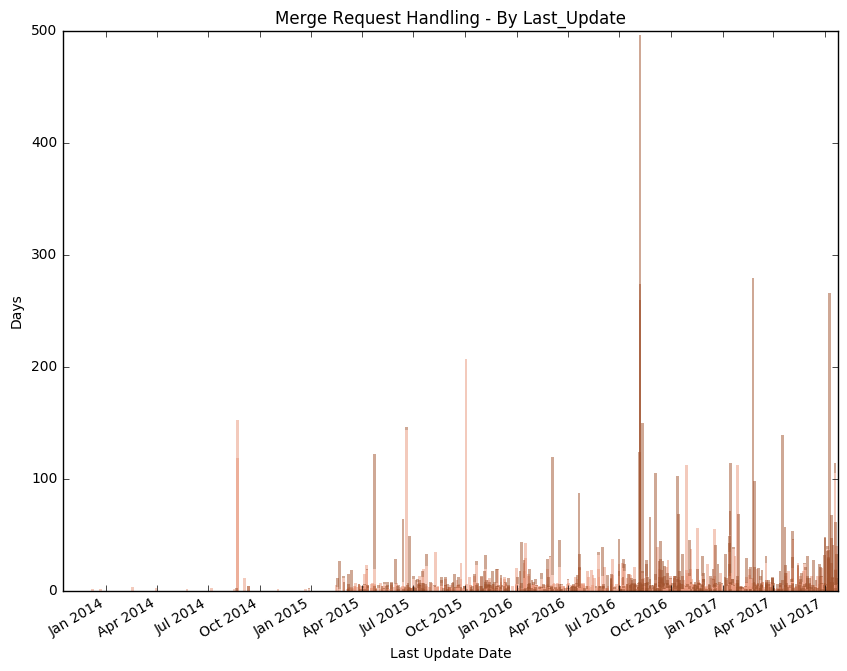

In [324]:
ax = plt.axes()
fmt = mdates.DateFormatter('%b %Y')
loc = mdates.MonthLocator([1,4,7,10])
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_major_locator(loc)

# ax.set_ylim(0,150)


plt.bar(
    mdates.date2num(df_filter['ts_last_update']), 
    (df_filter['ts_review_start'] - df_filter['ts_created']).astype('timedelta64[D]'), 
    color='darksalmon',
    linewidth=0,
    width=5,
    alpha=0.5,
)
plt.bar(
    mdates.date2num(df_filter['ts_last_update']), 
    (df_filter['ts_last_update'] - df_filter['ts_review_start']).astype('timedelta64[D]'), 
    bottom=(df_filter['ts_review_start'] - df_filter['ts_created']).astype('timedelta64[D]'), 
    color='sienna',
    linewidth=0,
    width=5,
    alpha=0.5,
)

plt.title("Merge Request Handling - By Last_Update")
plt.xlabel("Last Update Date")
plt.ylabel("Days")

fig = plt.figure(1)
fig.set_size_inches(w=10, h=8)
fig.autofmt_xdate()

plt.show()


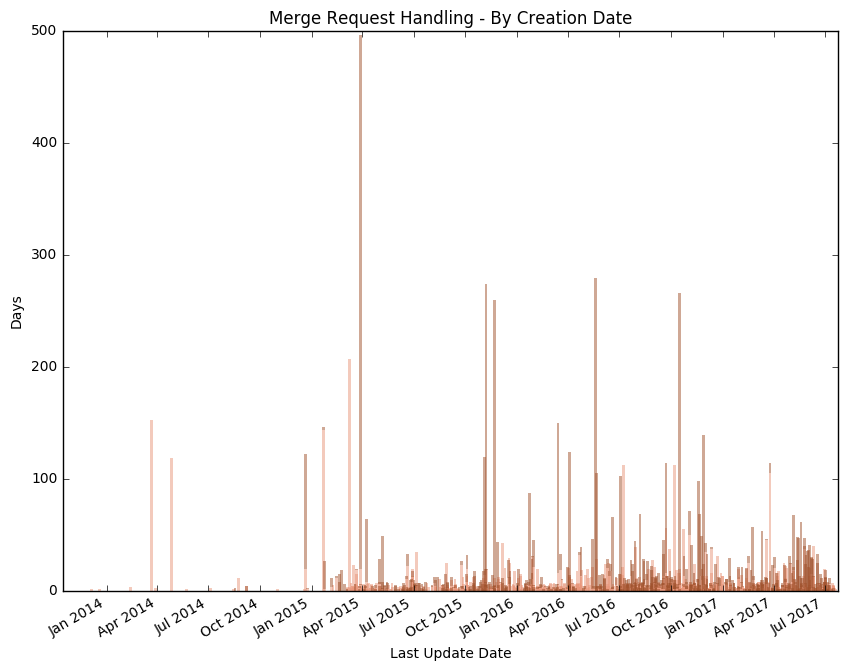

In [325]:
ax = plt.axes()
fmt = mdates.DateFormatter('%b %Y')
loc = mdates.MonthLocator([1,4,7,10])
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_major_locator(loc)

# ax.set_ylim(0,150)


plt.bar(
    mdates.date2num(df_filter['ts_created']), 
    (df_filter['ts_review_start'] - df_filter['ts_created']).astype('timedelta64[D]'), 
    color='darksalmon',
    linewidth=0,
    width=5,
    alpha=0.5,
)
plt.bar(
    mdates.date2num(df_filter['ts_created']), 
    (df_filter['ts_last_update'] - df_filter['ts_review_start']).astype('timedelta64[D]'), 
    bottom=(df_filter['ts_review_start'] - df_filter['ts_created']).astype('timedelta64[D]'), 
    color='sienna',
    linewidth=0,
    width=5,
    alpha=0.5,
)

plt.title('Merge Request Handling - By Creation Date')
plt.xlabel('Last Update Date')
plt.ylabel('Days')

fig = plt.figure(1)
fig.set_size_inches(w=10, h=8)
fig.autofmt_xdate()

plt.show()



In [326]:
start_date = datetime.datetime(2013,1,1)
# end_date = datetime.datetime(2018,1,1)  # fixed date
end_date = datetime.datetime.today()  # rolling date

stride = datetime.timedelta(7,0,0)  # weekly
# stride = datetime.timedelta(1,0,0)  # daily

opened_tickets = []
closed_tickets = []
merged_tickets = []
live_tickets = []

dates = [start_date + k*stride for k in range((end_date - start_date)//stride + 1)]

for date in dates:
    opened_tickets.append(df_filter[df_filter['ts_created']<date].shape[0])
    closed_tickets.append(
        df_filter[
            (df_filter['ts_last_update']<date) & (df_filter['state']=='closed')
        ]['ts_created'].shape[0])
    merged_tickets.append(
        df_filter[
            (df_filter['ts_last_update']<date) & (df_filter['state']=='merged')
        ]['ts_created'].shape[0])
    live_tickets.append(opened_tickets[-1] - closed_tickets[-1] - merged_tickets[-1])

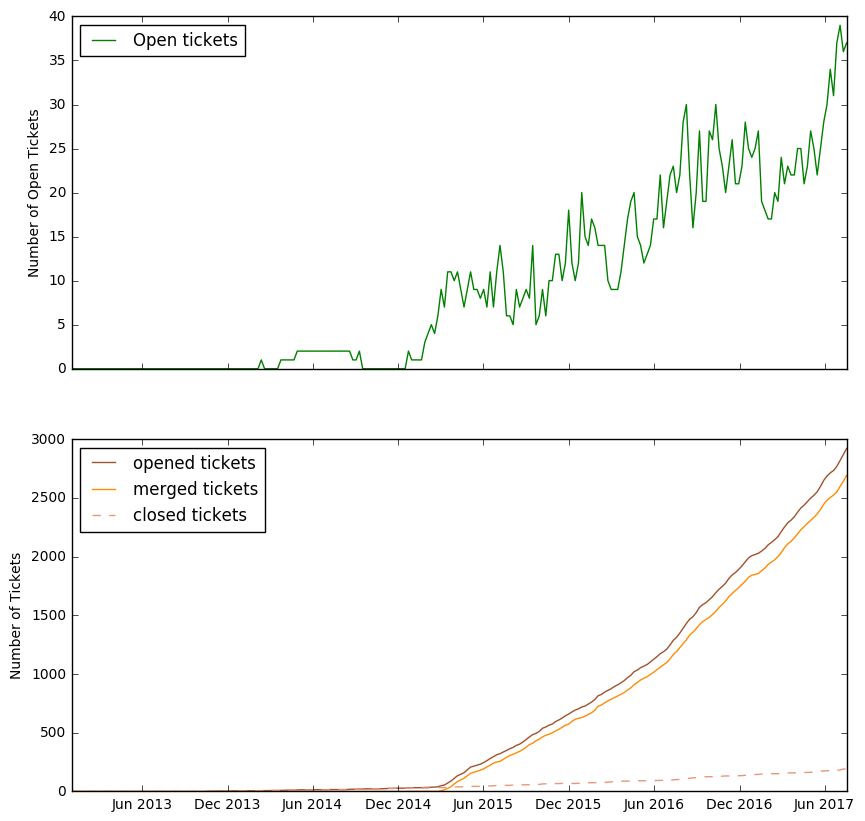

In [327]:
fig, axes = plt.subplots(2,1, squeeze=False, sharex = True)
fig.set_size_inches(w=10, h=10)

axes[0,0].plot_date(dates, live_tickets, color='green', linestyle='solid', marker=None, label='Open tickets')
axes[0,0].set_ylabel('Number of Open Tickets')
axes[0,0].legend(loc = 'upper left')

axes[1,0].plot_date(dates, opened_tickets, color='sienna', linestyle='solid', marker=None, label='opened tickets')
axes[1,0].plot_date(dates, merged_tickets, color='darkorange', linestyle='solid', marker=None, label='merged tickets')
axes[1,0].plot_date(dates, closed_tickets, color='darksalmon', linestyle='dashed', marker=None, label='closed tickets')
axes[1,0].set_ylabel('Number of Tickets')
axes[1,0].legend(loc = 'upper left')

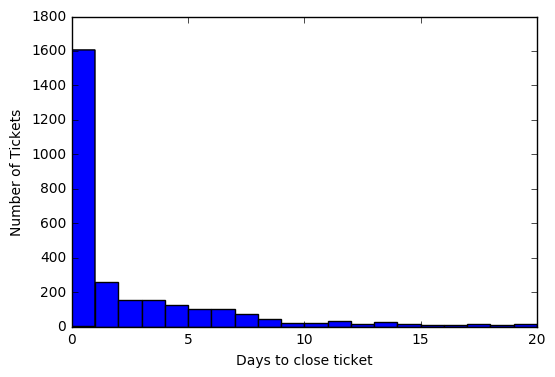

In [328]:
df_filter['duration'] = df_filter['ts_last_update']-df_filter['ts_created']

fig, ax = plt.subplots(1,1, squeeze = False)
ax[0,0].hist(duration.astype('timedelta64[D]'), bins = range(0,100))
ax[0,0].set_xlim(0,20)
ax[0,0].set_xlabel('Days to close ticket')
ax[0,0].set_ylabel('Number of Tickets')


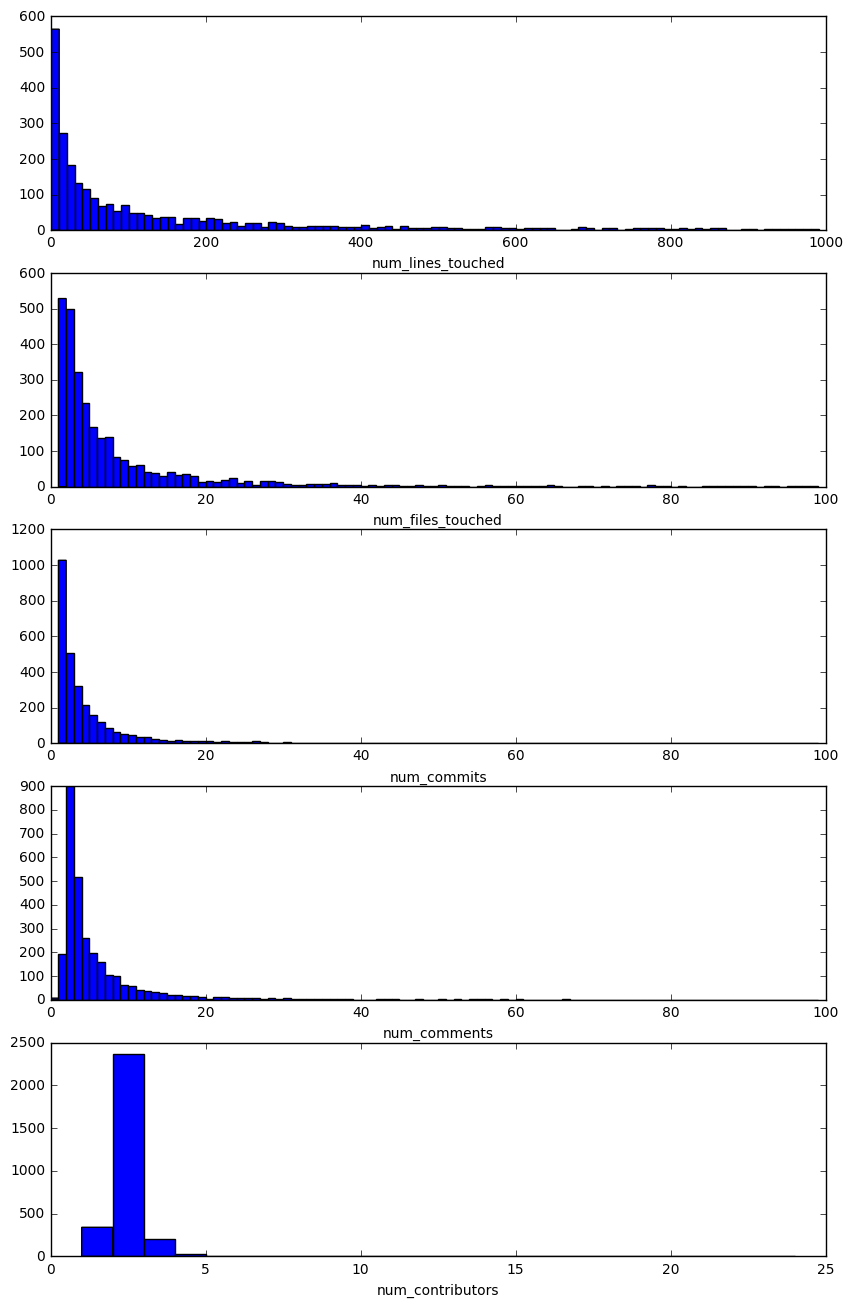

In [329]:
fig, axes = plt.subplots(5,1, squeeze=False)
fig.set_size_inches(w=10, h=16)

axes[0,0].set_xlabel('num_lines_touched')
axes[0,0].hist(df_filter['num_lines_touched'], bins = range(1,1000,10))

axes[1,0].hist(df_filter['num_files_touched'], bins = range(1,100))
axes[1,0].set_xlabel('num_files_touched')

axes[2,0].hist(df_filter['num_commits'], bins = range(1,100))
axes[2,0].set_xlabel('num_commits')

axes[3,0].hist(df_filter['num_comments'], bins = range(0,100))
axes[3,0].set_xlabel('num_comments')

axes[4,0].hist(df_filter['num_contributors'], bins = range(1,25))
axes[4,0].set_xlabel('num_contributors')


In [330]:
boundaries = [datetime.datetime(y,1,1) for y in range(2014,2019)]
yearly_groups = df_filter.groupby((
    pd.cut(
        mdates.date2num(df_filter['ts_created']), 
        mdates.date2num(boundaries), 
        labels = boundaries[0:-1]
    ),
    df_filter.state,
))

(0, 500)

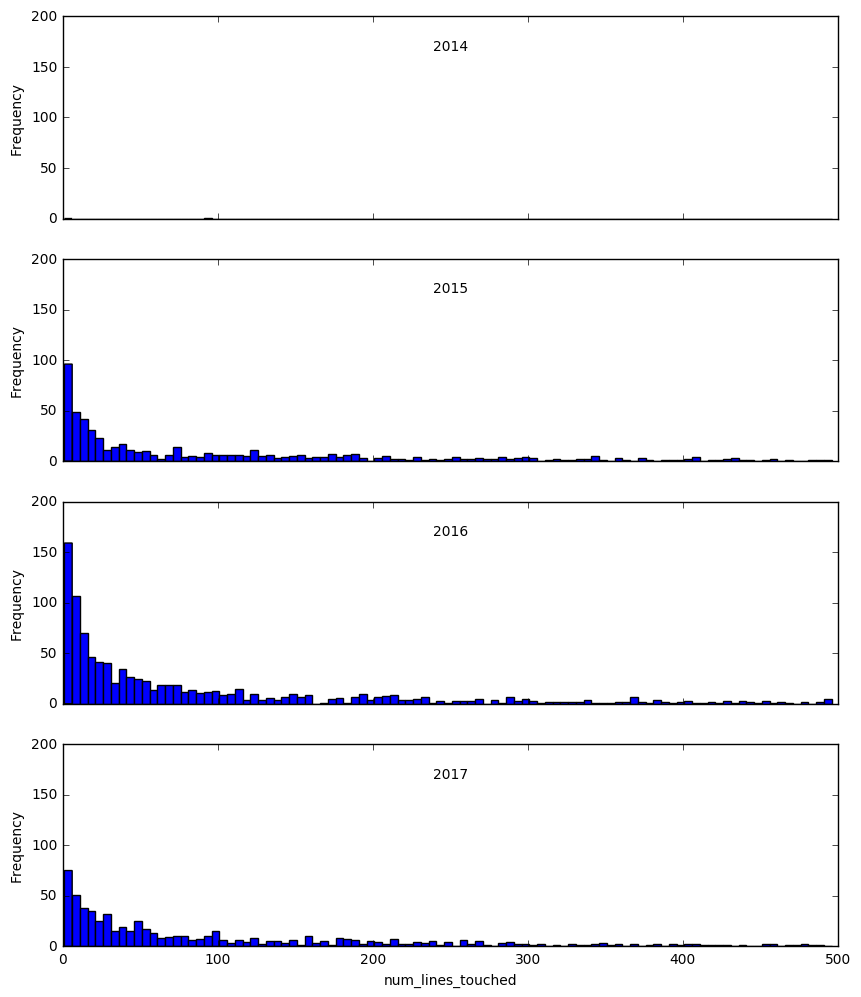

In [331]:
ylim = (0, 200)
xlim = (0, 500)
colname = 'num_lines_touched'

fig, axes = plt.subplots(len(boundaries)-1, 1, squeeze=False, sharex=True)
fig.set_size_inches(w=10, h=12)

i = -1
for (name, state), group in yearly_groups:
    if state == 'merged':
        i += 1
        ax = axes[i,0]
        ax.hist(group[colname], bins=range(1, xlim[1], 5))
        ax.set_ylim(ylim)
        ax.set_ylabel('Frequency')
        ax.text(xlim[1]/2, ylim[1]*5/6, name.year, ha='center')

ax.set_xlabel(colname)
ax.set_xlim(xlim)

(0, 50)

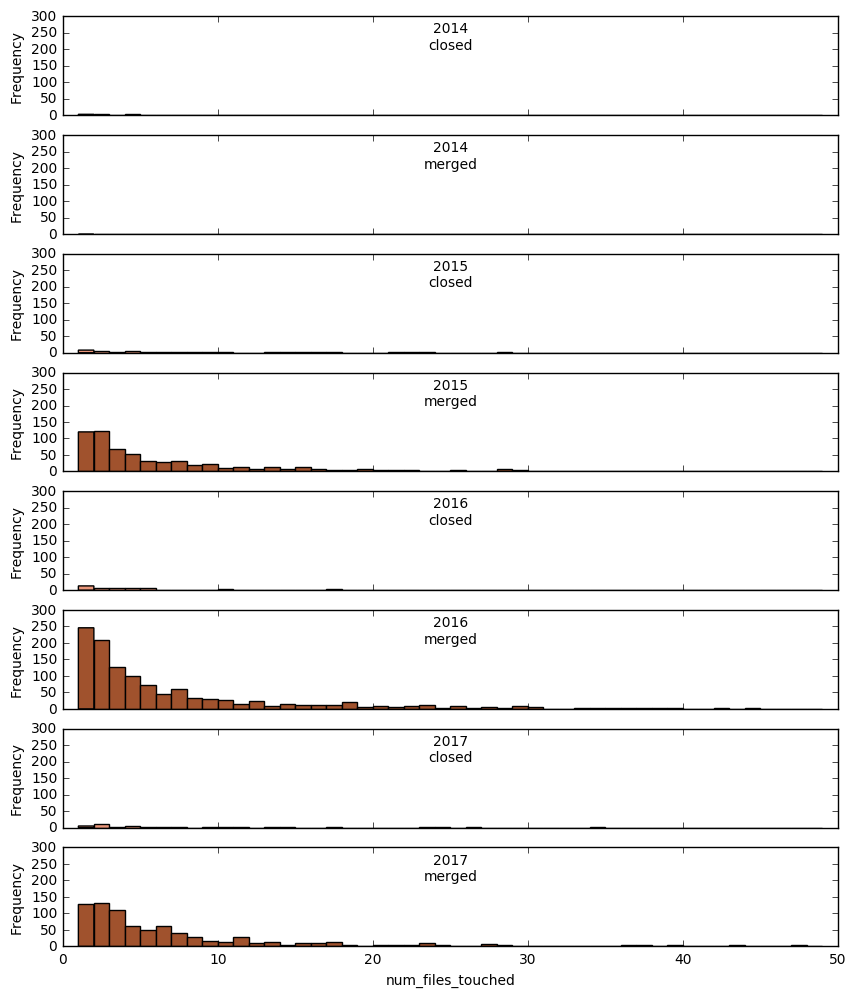

In [343]:
ylim = (0, 300)
xlim = (0, 50)
colname = 'num_files_touched'
colourmap = {'closed': 'darksalmon',
             'merged': 'sienna'}

fig, axes = plt.subplots(2*(len(boundaries)-1), 1, squeeze=False, sharex=True)
fig.set_size_inches(w=10, h=12)

i = 0
for name, group in yearly_groups:
    if name[1] in ['closed', 'merged']:
        ax = axes[i,0]
        ax.hist(group[colname], bins=range(1, xlim[1]), color = colourmap[name[1]])
        ax.set_ylim(ylim)
        ax.set_ylabel('Frequency')
        ax.text(xlim[1]/2, ylim[1]*5/6, name[0].year, ha='center')
        ax.text(xlim[1]/2, ylim[1]*4/6, name[1], ha='center')
        i += 1

ax.set_xlabel(colname)
ax.set_xlim(xlim)

(0, 50)

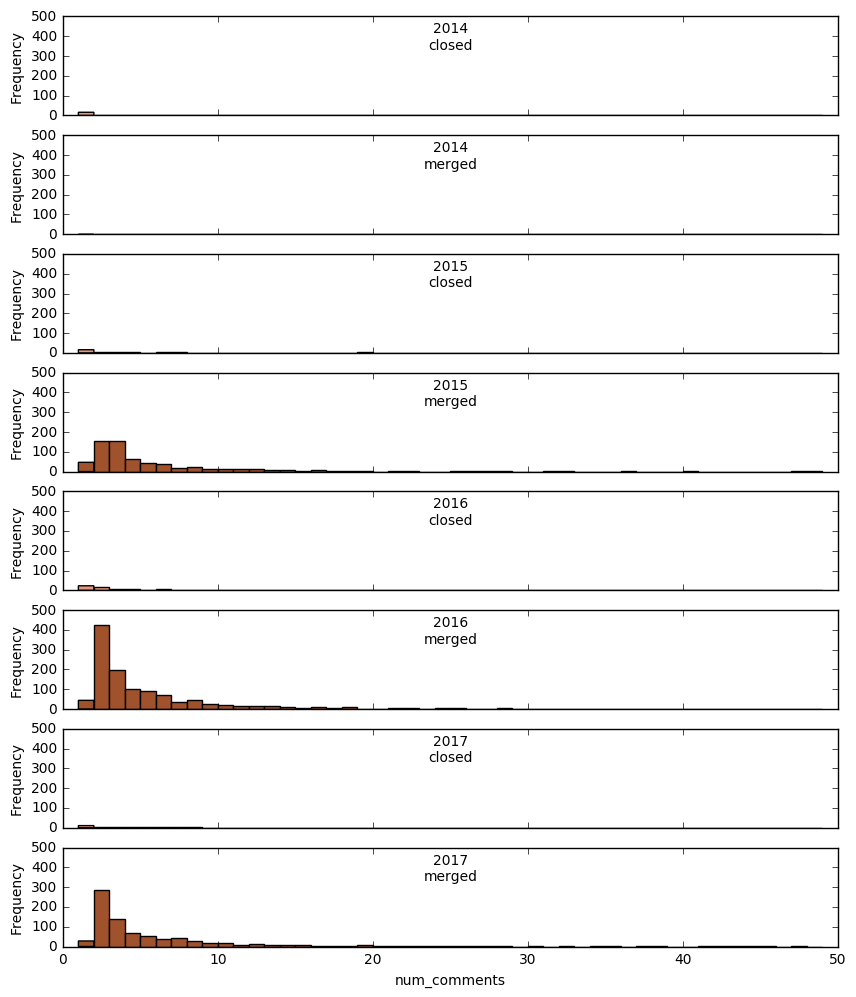

In [347]:
ylim = (0, 500)
xlim = (0, 50)
colname = 'num_comments'
colourmap = {'closed': 'darksalmon',
             'merged': 'sienna'}

fig, axes = plt.subplots(2*(len(boundaries)-1), 1, squeeze=False, sharex=True)
fig.set_size_inches(w=10, h=12)

i = 0
for name, group in yearly_groups:
    if name[1] in ['closed', 'merged']:
        ax = axes[i,0]
        ax.hist(group[colname], bins=range(1, xlim[1]), color = colourmap[name[1]])
        ax.set_ylim(ylim)
        ax.set_ylabel('Frequency')
        ax.text(xlim[1]/2, ylim[1]*5/6, name[0].year, ha='center')
        ax.text(xlim[1]/2, ylim[1]*4/6, name[1], ha='center')
        i += 1

ax.set_xlabel(colname)
ax.set_xlim(xlim)

(0, 50)

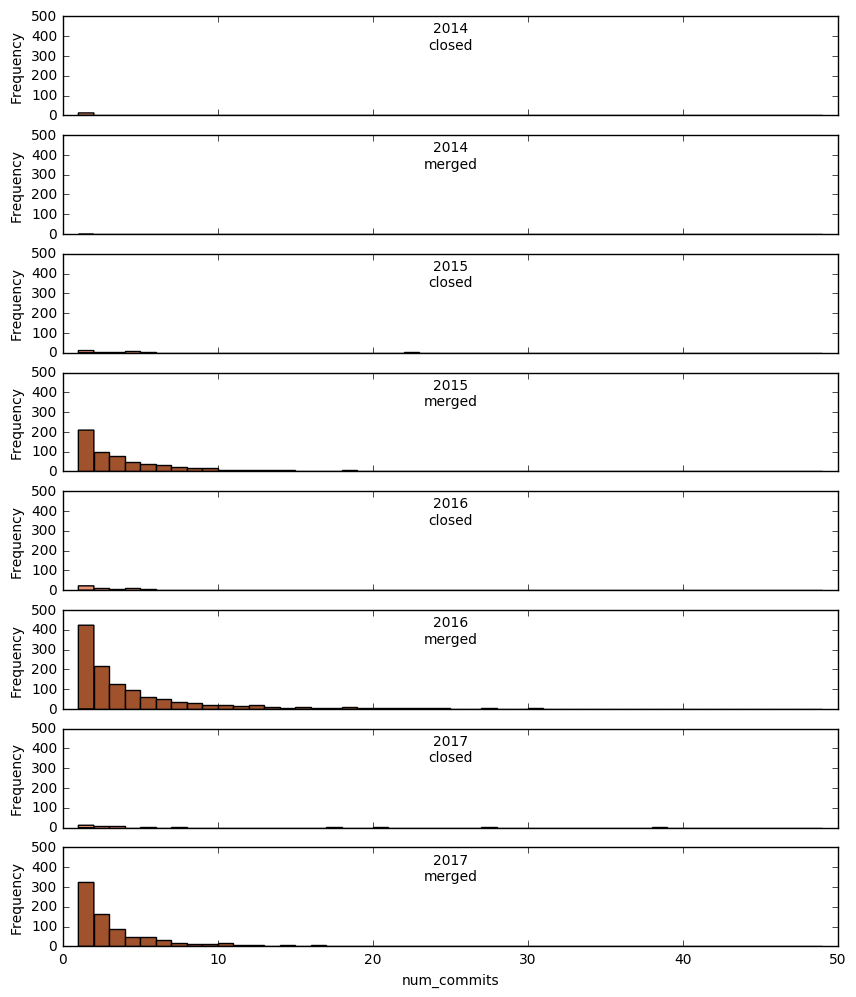

In [348]:
ylim = (0, 500)
xlim = (0, 50)
colname = 'num_commits'
colourmap = {'closed': 'darksalmon',
             'merged': 'sienna'}

fig, axes = plt.subplots(2*(len(boundaries)-1), 1, squeeze=False, sharex=True)
fig.set_size_inches(w=10, h=12)

i = 0
for name, group in yearly_groups:
    if name[1] in ['closed', 'merged']:
        ax = axes[i,0]
        ax.hist(group[colname], bins=range(1, xlim[1]), color = colourmap[name[1]])
        ax.set_ylim(ylim)
        ax.set_ylabel('Frequency')
        ax.text(xlim[1]/2, ylim[1]*5/6, name[0].year, ha='center')
        ax.text(xlim[1]/2, ylim[1]*4/6, name[1], ha='center')
        i += 1

ax.set_xlabel(colname)
ax.set_xlim(xlim)